In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

In [ ]:
!cp '/content/gdrive/MyDrive/kaggle Competition/kaggle.json' 'kaggle.json'

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mfaaris/spotify-app-reviews-2022

  0% 0.00/4.04M [00:00<?, ?B/s]
100% 4.04M/4.04M [00:00<00:00, 43.1MB/s]


In [ ]:
!unzip /content/spotify-app-reviews-2022.zip

Archive:  /content/spotify-app-reviews-2022.zip
  inflating: reviews.csv             


## Data Understanding

In [ ]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = pd.read_csv("reviews.csv")
data.drop(["Time_submitted", "Reply", "Total_thumbsup"], axis=1, inplace=True)
data

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
...,...,...
61589,Even though it was communicated that lyrics fe...,1
61590,"Use to be sooo good back when I had it, and wh...",1
61591,This app would be good if not for it taking ov...,2
61592,The app is good hard to navigate and won't jus...,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  61594 non-null  object
 1   Rating  61594 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


### Rating Column

In [ ]:
def rating(score) :
  if score > 3:
    return 'Good'
  elif score == 3:
    return "Netral"
  else :
    return "Bad"

In [ ]:
data["Rating"] = data["Rating"].apply(rating)
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality...",Good
1,Please ignore previous negative rating. This a...,Good
2,"This pop-up ""Get the best Spotify experience o...",Good
3,Really buggy and terrible to use as of recently,Bad
4,Dear Spotify why do I get songs that I didn't ...,Bad
5,The player controls sometimes disappear for no...,Netral
6,I love the selection and the lyrics are provid...,Good
7,Still extremely slow when changing storage to ...,Netral
8,It's a great app and the best mp3 music app I ...,Good
9,"I'm deleting this app, for the following reaso...",Bad


Text(0.5, 1.0, 'Rating Distribution Across Dataset\nAfter Transformation')

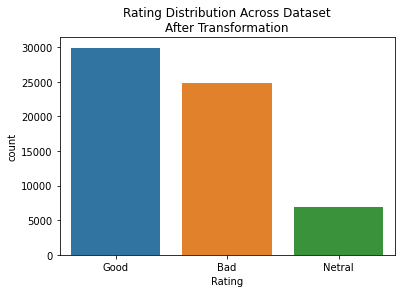

In [ ]:
ax = sns.countplot(data=data, x='Rating')
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')

### Review

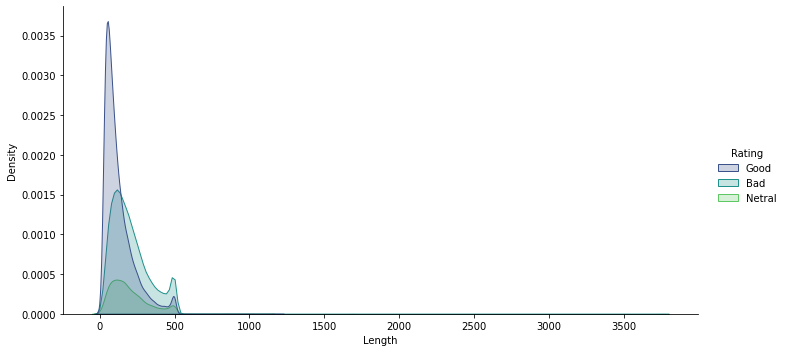

In [ ]:
data['Length'] = data['Review'].apply(len)
ax = sns.displot(data=data, x='Length', hue='Rating', kind='kde', fill=True, aspect=2, palette='viridis')

Text(0.5, 1.0, 'Distribution of review Length\nfor Each Rating')

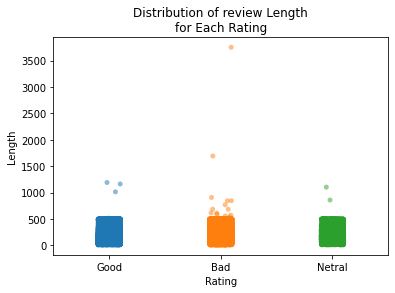

In [ ]:
ax = sns.stripplot(data=data, x='Rating', y='Length', alpha=0.5)
ax.set_title('Distribution of review Length\nfor Each Rating')

Text(0.5, 1.0, 'Average of review Length\nfor Each Rating')

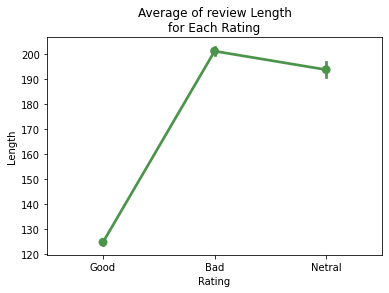

In [ ]:
ax = sns.pointplot(data=data, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')

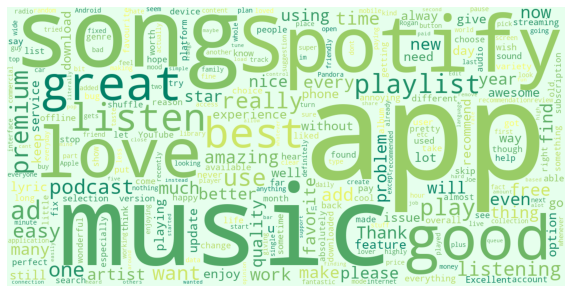

In [ ]:
good = data[data['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)

In [ ]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [ ]:
top_words(good)

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


## Text PreProcessing

In [ ]:
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",Good,112
1,Please ignore previous negative rating. This a...,Good,86
2,"This pop-up ""Get the best Spotify experience o...",Good,106
3,Really buggy and terrible to use as of recently,Bad,47
4,Dear Spotify why do I get songs that I didn't ...,Bad,100


In [ ]:
length_before = data['Length'].sum()

In [ ]:
print('Original:')
print(data['Review'][7])
print()

sentence = []
for word in data['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my searches or playlists.

Lemmatization:
Still extremely slow when change storage to external sd card.. I'm convince this be do on purpose, spotify know of this issue and have do NOTHING to solve it! Over time I have change sd cards, each be faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my search or playlists.


In [ ]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [ ]:
data['Review'] = data['Review'].apply(cleaning)

In [ ]:
data['Length'] = data['Review'].apply(len)
length_after = data['Length'].sum()

print('Total word before cleaning: {}'.format(length_before))
print('Total word after cleaning: {}'.format(length_after))

Total word before cleaning: 10059745
Total word after cleaning: 6210516


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data['Rating'], test_size=0.2)
print(f"x train : {len(X_train)}")
print(f"x test : {len(X_test)}")
print(f"y train : {len(y_train)}")
print(f"y test : {len(y_test)}")

x train : 49275
x test : 12319
y train : 49275
y test : 12319


## Build Model

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 25628


### Long Short-Term Memory (LSTM)

In [ ]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           205024    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3200      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                        

In [ ]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
1540/1540 [==============================] - 33s 16ms/step - loss: 1.0041 - accuracy: 0.4594 - val_loss: 0.9623 - val_accuracy: 0.4836
Epoch 2/25
1540/1540 [==============================] - 25s 16ms/step - loss: 0.9308 - accuracy: 0.5541 - val_loss: 0.7883 - val_accuracy: 0.6903
Epoch 3/25
1540/1540 [==============================] - 24s 16ms/step - loss: 0.7713 - accuracy: 0.7134 - val_loss: 0.6482 - val_accuracy: 0.7671
Epoch 4/25
1540/1540 [==============================] - 24s 16ms/step - loss: 0.7040 - accuracy: 0.7535 - val_loss: 0.6093 - val_accuracy: 0.7750
Epoch 5/25
1540/1540 [==============================] - 24s 16ms/step - loss: 0.6626 - accuracy: 0.7691 - val_loss: 0.5945 - val_accuracy: 0.7790
Epoch 6/25
1540/1540 [==============================] - 24s 15ms/step - loss: 0.6387 - accuracy: 0.7782 - val_loss: 0.5811 - val_accuracy: 0.7833
Epoch 7/25
1540/1540 [==============================] - 27s 18ms/step - loss: 0.6152 - accuracy: 0.7835 - val_loss: 0.5752 -

### Gated recurrent units (GRU)

In [ ]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           205024    
                                                                 
 gru (GRU)                   (None, 8)                 432       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 205,483
Trainable params: 205,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
1540/1540 [==============================] - 17s 10ms/step - loss: 0.9942 - accuracy: 0.4801 - val_loss: 0.9261 - val_accuracy: 0.4837
Epoch 2/25
1540/1540 [==============================] - 15s 9ms/step - loss: 0.8819 - accuracy: 0.5931 - val_loss: 0.7931 - val_accuracy: 0.6973
Epoch 3/25
1540/1540 [==============================] - 14s 9ms/step - loss: 0.7513 - accuracy: 0.7188 - val_loss: 0.6693 - val_accuracy: 0.7620
Epoch 4/25
1540/1540 [==============================] - 14s 9ms/step - loss: 0.6747 - accuracy: 0.7645 - val_loss: 0.6992 - val_accuracy: 0.7273
Epoch 5/25
1540/1540 [==============================] - 15s 10ms/step - loss: 0.6435 - accuracy: 0.7766 - val_loss: 0.6275 - val_accuracy: 0.7679
Epoch 6/25
1540/1540 [==============================] - 15s 10ms/step - loss: 0.6229 - accuracy: 0.7835 - val_loss: 0.7432 - val_accuracy: 0.7208
Epoch 7/25
1540/1540 [==============================] - 14s 9ms/step - loss: 0.6085 - accuracy: 0.7888 - val_loss: 0.6005 - val

## Evaluasi

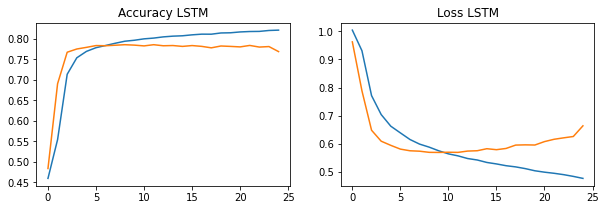

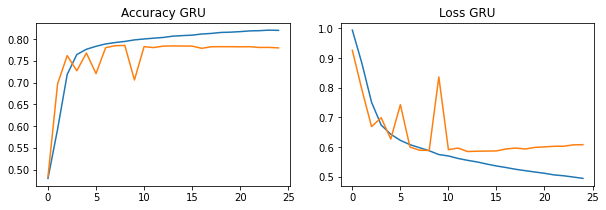

In [ ]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_gru = pd.DataFrame(model_gru.history.history)


f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(metrics_lstm[['accuracy', 'val_accuracy']])
ax2.plot(metrics_lstm[['loss', 'val_loss']])
ax.set_title("Accuracy LSTM")
ax2.set_title("Loss LSTM")
plt.show()

f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(metrics_gru[['accuracy', 'val_accuracy']])
ax2.plot(metrics_gru[['loss', 'val_loss']])
ax.set_title("Accuracy GRU")
ax2.set_title("Loss GRU")
plt.show()

## Prediction Test

In [ ]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    result = lb.inverse_transform(pred)[0]
    
    return result

def gru_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_gru.predict(padded)
    result = lb.inverse_transform(pred)[0]
    
    return result

In [ ]:
text = {
  "text 1" : "Please fix this problem, when i hear music from this app and let it play at background, the music will suddenly stop",
  "text 2" : "The best application for music play, for the price, it is still adorable for user",
  "text 3" : "add easier features like in the computer, its too complicated that i cant even loop and pick my own song",
  "text 4" : "If you want to play music in this application, please press the play button and use a headset" 
}

for key, value in text.items():
  print(key)
  print('LSTM\t: ', lstm_prediction(value))
  print('GRU\t: ', gru_prediction(value))
  print()

text 1
LSTM	:  Bad
GRU	:  Bad

text 2
LSTM	:  Good
GRU	:  Good

text 3
LSTM	:  Bad
GRU	:  Bad

text 4
LSTM	:  Bad
GRU	:  Bad

